In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.misc as misc
import math
import imageio
import time

# Libwallerlab imports
import llops.operators as ops
import llops as yp
import llops.simulation as sim
from llops import vec

## Define Backend and Datatype

In [2]:
global_backend = 'numpy' # arrayfire or numpy
global_dtype = 'complex32' # complex32 or complex64

ops.setDefaultBackend(global_backend)
ops.setDefaultDatatype(global_dtype)

## Define Test Object and Forward Operator

<IPython.core.display.Javascript object>


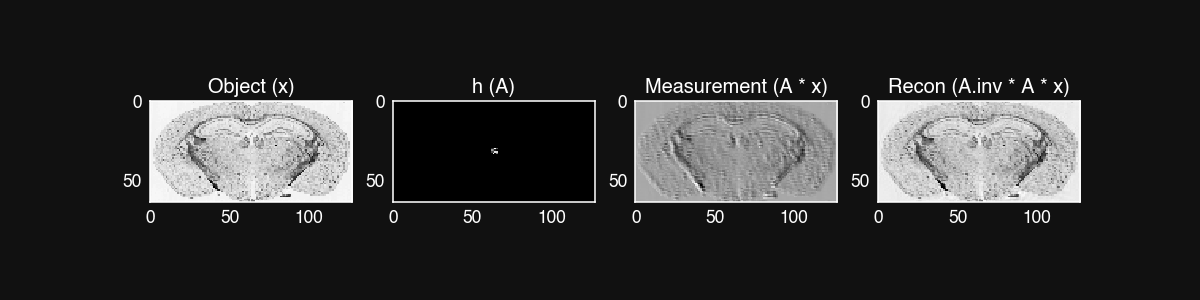

In [3]:
# Image size to simulate
image_size = np.array([64, 128])

# Determine machine precision threshold
eps = yp.precision(global_dtype) * np.prod(image_size)

# Load object and crop to size
x = sim.brain(image_size)

# Generate convolution kernel h
h_size = np.array([4, 4])
h = yp.zeros(image_size, global_dtype, global_backend)
h[image_size[0] // 2 - h_size[0] // 2:image_size[0] // 2 + h_size[0] // 2,
  image_size[1] // 2 - h_size[1] // 2:image_size[1] // 2 + h_size[1] // 2] = yp.randn((h_size[0], h_size[1]), global_dtype, global_backend)

h /= yp.scalar(yp.sum(yp.abs(h)))

# Forward Operator
A = ops.Convolution(h, mode='circular', pad_value='mean', invalid_support_value=0)
A.inverse_regularizer = 1e-2

# Generate Measurement
y = A * x

# Reconstruction
x_star = A.inv * y

# Show object and h
plt.figure(figsize=(12,3))
plt.subplot(141)
plt.imshow(yp.abs(yp.changeBackend(x, 'numpy')), cmap='gray')
plt.title('Object (x)')
plt.subplot(142)
plt.imshow(yp.abs(np.asarray(h)), cmap='gray')
plt.title('h (A)')
plt.subplot(143)
plt.imshow((yp.abs(np.asarray(y))), cmap='gray')
plt.title('Measurement (A * x)');
plt.subplot(144)
plt.imshow((yp.abs(np.asarray(x_star))), cmap='gray')
plt.title('Recon (A.inv * A * x)');

## Identity Operator

In [4]:
I = ops.Identity(image_size)

# Check forward operator
assert yp.sum((I * x) - x) < eps

# Check gradient
I.gradient_check()

# Render forward model
I.latex()

# Render gradient
I.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Diagonalization Operator

In [5]:
K = ops.Diagonalize(h)

# Check forward operator
yp.assert_equality(K * x, h * x)

# Check gradient
K.gradient_check()

# Render forward model
K.latex()

# Render gradient
K.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Matrix Multiplication Operator

In [6]:
matrix_size = (10,10)
m = yp.rand(matrix_size, global_dtype, global_backend)
xm = yp.rand(matrix_size[1], global_dtype, global_backend)
M = ops.MatrixMultiply(m)

# Check Forward operator
assert yp.sum(yp.abs(yp.vec(yp.changeBackend(M * xm, 'numpy')) - yp.vec(yp.changeBackend(m, 'numpy').dot(yp.changeBackend(xm, 'numpy'))))) < eps, "%f" % yp.sum(yp.abs(yp.changeBackend(M * xm, 'numpy') - yp.changeBackend(m, 'numpy').dot(yp.changeBackend(xm, 'numpy'))[:, np.newaxis]))

# Check Adjoint
assert yp.sum(yp.abs(yp.vec(yp.changeBackend(M.H * xm, 'numpy')) - yp.vec(np.conj(yp.changeBackend(m, 'numpy').T).dot(yp.changeBackend(xm, 'numpy'))))) < eps, "%f" % yp.sum(yp.abs(yp.changeBackend(M.H * xm, 'numpy') - np.conj(yp.changeBackend(m, 'numpy').T).dot(yp.changeBackend(xm, 'numpy'))[:, np.newaxis]))

# Check gradient
M.gradient_check()

# Render forward model
M.latex()

# Render gradient
M.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Circular Convolution Operator

In [7]:
# Generate circular convolution operator
C = ops.Convolution(h)

# Test forward operator
conv2 = lambda x, h: yp.changeBackend(np.fft.ifftshift((np.fft.ifft2(np.fft.fft2(x, axes=(0,1), norm='ortho') * np.fft.fft2(h, axes=(0,1), norm='ortho'), axes=(0,1), norm='ortho')), axes=(0,1)).astype(yp.getNativeDatatype(global_dtype, 'numpy')), global_backend)

x_np = yp.changeBackend(x, 'numpy')
h_np = yp.changeBackend(h, 'numpy')

# Check gradient
C.gradient_check(eps=1e-0)

# Render forward model
C.latex()

# Render gradient
C.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Non-circular Convolution Operator

<IPython.core.display.Javascript object>


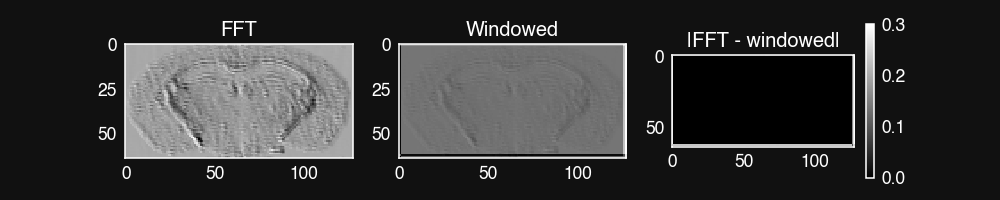

SSD is 7.55E+03


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [8]:
pad_value = 0

# Windowed Convolution
C_full = ops.Convolution(h, mode='same', pad_value=pad_value, dtype=global_dtype, backend=global_backend)
y_full = yp.changeBackend(yp.abs(C_full * x), 'numpy')

# Circular Convolution
C = ops.Convolution(h,  dtype=global_dtype, backend=global_backend)
y5 = yp.abs(yp.changeBackend(C * x, 'numpy'))

plt.figure(figsize=(10,2))
plt.subplot(131)
plt.imshow(yp.real(y5))
plt.title('FFT')
plt.subplot(132)
plt.imshow(yp.real(y_full))
plt.title('Windowed')
plt.subplot(133)
plt.imshow(yp.abs(y_full - y5))
plt.title('|FFT - windowed|');
plt.colorbar()

print('SSD is %.2E' % yp.sum(yp.abs(y_full - y5)) ** 2)

# Check Gradient
C_full.gradient_check()

# Render forward model
C_full.latex()

# Render gradient
C_full.latex(gradient=True)

## Cross-Correlation Operator

In [9]:
XC = ops.CrossCorrelation(h)

xc = lambda x, h: np.fft.ifftshift((np.fft.ifft2(np.fft.fft2(x, axes=(0,1), norm='ortho') \
                                                                * np.conj(np.fft.fft2(h, axes=(0,1), norm='ortho')), axes=(0,1), norm='ortho')), axes=(0,1)).astype(np.complex64)

# Check forward operator
# y1 = yp.changeBackend(XC * vec(x), 'numpy')
# y2 = xc(yp.changeBackend(x, 'numpy'), yp.changeBackend(h, 'numpy'))
# assert yp.sum(yp.abs(y1 - y2.reshape(-1))) < eps

# Check gradient
XC.gradient_check()

# Render forward model
XC.latex()

# Render gradient
XC.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Crop Operator: Centered

In [10]:
# Generate Crop Operator
crop_size = (image_size[0] // 2, image_size[1] // 2)
crop_start = tuple(np.asarray(image_size) // 2 - np.asarray(crop_size) // 2)
CR = ops.Crop(image_size, crop_size, pad_value=0, crop_start=crop_start, dtype=global_dtype, backend=global_backend)

# Check forward operator
y_1 = yp.changeBackend(CR * x, 'numpy')
y_2 = yp.changeBackend(yp.crop(x, crop_size, crop_start), 'numpy')
assert yp.sum(yp.abs(y_1 - y_2)) < eps

# Check Adjoint Operator
pad_size = [int((image_size[i] - crop_size[i]) / 2) for i in range(len(image_size))]
y_3 = yp.pad(yp.crop(x, crop_size, crop_start), image_size, crop_start, pad_value=0)
y_4 = CR.H * CR * x
assert yp.sum(yp.abs(y_3 - y_4)) < eps

# Check gradient
CR.gradient_check()

# Render forward model
CR.latex()

# Render gradient
CR.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Crop Operator: Non-Centered

In [11]:
# Generate Crop Operator
crop_size = (image_size[0] // 2, image_size[1] // 2)
crop_start = (6, 6)
CR = ops.Crop(image_size, crop_size, pad_value=0,  dtype=global_dtype, backend=global_backend, crop_start=crop_start)

# Check forward operator
y_1 = yp.changeBackend(CR * x, 'numpy')
y_2 = yp.changeBackend(yp.crop(x, crop_size, crop_start), 'numpy')
assert yp.sum(yp.abs(y_1 - y_2)) < eps

# Check Adjoint Operator
pad_size = [int((image_size[i] - crop_size[i]) / 2) for i in range(len(image_size))]
y_3 = yp.pad(yp.crop(x, crop_size, crop_start), image_size, crop_start, pad_value=0)
y_4 = yp.reshape(CR.H * CR * x, image_size)
assert yp.sum(yp.abs(y_3 - y_4)) < eps

# Check gradient
CR.gradient_check()

# Render forward model
CR.latex()

# Render gradient
CR.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Shift Operator

In [12]:
# Normal shift
shift = (0, 10) # should be y, x
T = ops.Shift(image_size, shift)

def shift_func(x, shift):
    x = yp.changeBackend(x, 'numpy')
    for ax, sh in enumerate(shift):
        x = np.roll(x, int(sh), axis=ax)
    return(x)
 
# Check Forward Operator
y_1 = yp.changeBackend(T * x, 'numpy')
y_2 = shift_func(yp.changeBackend(x, 'numpy'), shift)
assert yp.sum(yp.abs(y_1 - y_2)) < eps

# Check Adjoint Operator
assert yp.sum(yp.abs(T.H * T * x - x)) < eps

# Check gradient
T.gradient_check()

# Render forward model
T.latex()

# Render gradient
T.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Summation Operator

In [13]:
axis_to_sum = (0,1)
Σ = ops.Sum(image_size)

# Check forward operator
y_1 = yp.changeBackend(Σ * x, 'numpy')
y_2 = yp.sum(yp.changeBackend(x, 'numpy'), axis=axis_to_sum)
assert yp.abs(yp.sum(y_1 - y_2)) < eps

# Check adjoint operator
y_3 = yp.changeBackend(Σ.H * Σ * x, 'numpy')
reps = [1, ] * len(image_size)
axes = list(range(len(image_size))) if axis_to_sum is 'all' else axis_to_sum
scale = 1
for axis in axes:
    reps[axis] = image_size[axis]
    scale *= 1 / image_size[axis]
y_4 = yp.tile(y_2, reps) * scale
assert yp.sum(yp.abs(y_3 - y_4)) < eps

# Check gradient
# Σ.gradient_check(eps=1)

# Render forward model
Σ.latex()

# Render gradient
Σ.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Mean Operator

## Intensity Operator

In [14]:
I = ops.Intensity(image_size)

# Check forward operator
assert yp.sum(yp.abs((yp.abs(yp.changeBackend(x, 'numpy')) ** 2) - yp.changeBackend(I * x, 'numpy'))) < eps

# Check gradient
I.gradient_check()

# Render forward model
I.latex()

# Render gradient
I.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Flip Operator

In [15]:
flip_axis = 0
L = ops.Flip(image_size, axis=flip_axis)

# Check forward operator
assert yp.sum(yp.abs(L * x - yp.flip(x, flip_axis))) < eps, "%f" % yp.sum(yp.abs(L * x - vec(yp.flip(x, flip_axis)))) 

# Check gradient
L.gradient_check()

# Render forward model
L.latex()

# Render gradient
L.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## $\ell2$ Norm Operator

In [16]:
L2 = ops.L2Norm(image_size)

# Check forward operator
assert yp.sum(yp.abs(L2 * x - 0.5 * yp.norm(x) ** 2)) < eps, '%f' % yp.sum(yp.abs(L2 * x - 0.5 * np.linalg.norm(x) ** 2))

# Check gradient
L2.gradient_check()

# Render forward model
L2.latex()

# Render gradient
L2.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## $\ell1 $ Norm Operator

In [17]:
L1 = ops.L1Norm(image_size)

# Forward operator
assert L1 * x - yp.sum(yp.abs(x)) < eps

# Render forward model
L1.latex()

<IPython.core.display.Latex object>

## Wavelet Transform

In [18]:
import pywt
wavelet_list = ['db1', 'haar', 'rbio1.1', 'bior1.1', 'bior4.4', 'sym12']
for wavelet_test in wavelet_list:
    # Wavelet Transform
    W = ops.WaveletTransform(image_size, wavelet_type=wavelet_test, use_cycle_spinning=False)

    # Check forward operation
    coeffs = pywt.wavedecn(x, wavelet=wavelet_test)
    x_wavelet, coeff_slices = pywt.coeffs_to_array(coeffs)
    assert yp.sum(yp.abs(yp.changeBackend(W * x, 'numpy') - x_wavelet)) < eps, "Difference %.6e"

    # Check inverse operation
    coeffs_from_arr = pywt.array_to_coeffs(x_wavelet, coeff_slices)
    cam_recon = pywt.waverecn(coeffs_from_arr, wavelet=wavelet_test)
    assert yp.sum(yp.abs(W.H * W * x - x)) < 1e-2

    # Ensure that the wavelet transform isn't just identity (weird bug)
    if W.shape[1] is yp.size(x):
        assert yp.sum(yp.abs(W * yp.vec(x) - yp.vec(x))) > 1e-2, "%s" % wavelet_test

    # Check gradient 
    W.gradient_check()

    # Render forward model
    W.latex()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Exponential Operator

In [19]:
L2 = ops.L2Norm(image_size)
F = ops.FourierTransform(image_size)
EXP = ops.Exponential(image_size)

# Forward model
assert yp.sum(yp.abs(yp.changeBackend(EXP * x, 'numpy') - np.exp(yp.changeBackend(x, 'numpy')))) < eps

# Check gradient
EXP.gradient_check()

# Generate composite operator
D = ops.Diagonalize(h)
L2 = ops.L2Norm(image_size)

EXP_COMP = L2 * F * EXP
EXP_COMP.gradient_check()

EXP_COMP_2 = L2 * F * EXP * D
EXP_COMP_2.gradient_check()

# Render forward model
EXP.latex()

# Render gradient
EXP.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Phase Ramp Operator

In [20]:
eps_phase_ramp = 1e-4
shift = yp.changeBackend(np.asarray((-5,3)).astype(yp.getNativeDatatype(global_dtype, 'numpy')), global_backend)

# Generate phase ramp
R = ops.PhaseRamp(image_size)
r = R * shift

F = ops.FourierTransform(image_size, dtype=global_dtype, normalize=False, backend=global_backend)
D_R = ops.Diagonalize(r, dtype=global_dtype)
S_R = F.H * D_R * F

# Pixel-wise shift operator
S = ops.Shift(image_size, shift)


# Check gradient of phase ramp convolution
S_R.gradient_check()

# Check gradient of phase ramp
print(R.gradient_check(eps=1))

# Render forward model
R.latex()

# Render gradient
R.latex(gradient=True)

# plt.figure()
# plt.subplot(131)
# plt.imshow(yp.abs(yp.reshape(yp.changeBackend(S_R * vec(x), 'numpy'), image_size)))
# plt.subplot(132)
# plt.imshow(yp.abs(yp.reshape(yp.changeBackend(S * vec(x), 'numpy'), image_size)))
# plt.subplot(133)
# plt.imshow(yp.abs(yp.reshape(yp.changeBackend(S * vec(x) - S_R * vec(x), 'numpy'), image_size)))

4.24405e-09


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Derivative Operator

In [21]:
# Derivatie operator in x
Dx = ops.Derivative(image_size, dtype=global_dtype, backend=global_backend, axis=1)
xd = Dx * x

# Derivative operator in y
Dy = ops.Derivative(image_size, dtype=global_dtype, backend=global_backend, axis=0)
yd = Dy * x

# True derivative grids for comparison
N = image_size
r_x = np.arange(-N[1] / 2, N[1] / 2, 1.0) / N[1]
r_y = np.arange(-N[0] / 2, N[0] / 2, 1.0) / N[0]
grid_np = np.meshgrid(r_x, r_y)

grid = []
for g in grid_np:
    grid.append(yp.changeBackend(g.astype(yp.getNativeDatatype(global_dtype, 'numpy')), global_backend))

# from libwallerlab.operators.fft import Ft, iFt
Ft = lambda x: np.fft.fftshift(np.fft.fft2(np.fft.fftshift(x, axes=(0, 1)), axes=(0, 1), norm='ortho'), axes=(0, 1))
iFt = lambda x: np.fft.fftshift(np.fft.ifft2(np.fft.fftshift(x, axes=(0, 1)), axes=(0, 1), norm='ortho'), axes=(0, 1))

dx_func = lambda x: iFt(Ft(x) * grid[1].reshape(image_size))
dy_func = lambda x: iFt(Ft(x) * grid[0].reshape(image_size))

# assert yp.sum(yp.abs(dx_func(x) - xd.reshape(image_size))) < eps, "X derivative was not equal! (%.4e)" % yp.sum(yp.abs(dx_func(x) - xd.reshape(image_size)))
# assert yp.sum(yp.abs(dy_func(x) - yd.reshape(image_size))) < eps, "Y derivative was not equal! (%.4e)" % yp.sum(yp.abs(dy_func(x) - yd.reshape(image_size)))

# Check Gradient
Dx.gradient_check()
Dy.gradient_check()

# Render forward models
Dx.latex()
Dy.latex()

# Render gradients
Dx.latex(gradient=True)
Dy.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Power Operator

In [22]:
power = 2
P = ops.Power(image_size, power,dtype=global_dtype, backend=global_backend)
assert yp.sum(yp.abs(yp.changeBackend(P * x, 'numpy') - yp.changeBackend(x, 'numpy') ** power)) < eps, "%f" % yp.sum(yp.abs(yp.changeBackend(P * x, 'numpy') - yp.changeBackend(x, 'numpy') ** power)) 

# Render forward model
P.latex()

# Render gradient
Σ.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## FFTShift Operator

In [23]:
S = ops.FFTShift(image_size)

yp.assert_equality(S * x, yp.fftshift(x))
yp.assert_equality(S.H * S * x, x)

# Check Gradient
S.gradient_check()

# Render Latex
S.latex()

# Render gradient
S.latex(gradient=True)

# plt.figure()
# plt.subplot(131)
# plt.imshow(yp.abs(x))
# plt.subplot(132)
# plt.imshow(yp.abs(S * x))
# plt.subplot(133)
# plt.imshow(yp.abs(S.H * S *  x))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Image Segmentation Operator

<IPython.core.display.Javascript object>


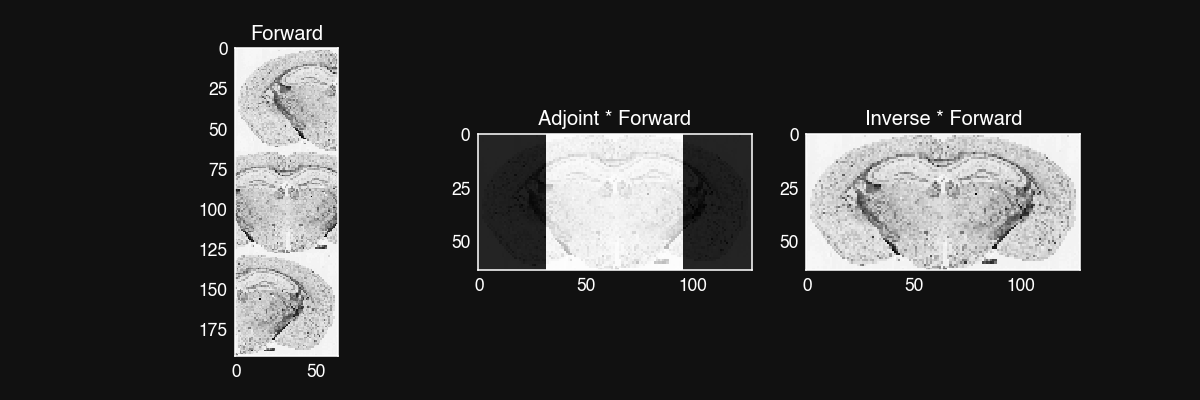

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [24]:
crop_size = crop_size = (image_size[0], image_size[0])

roi_list = [yp.Roi(crop_size, start=(0,0), input_shape=image_size),
            yp.Roi(crop_size, start=(0,image_size[1] // 4), input_shape=image_size),
            yp.Roi(crop_size, start=(0,image_size[1] // 2), input_shape=image_size)]

# roi_list[0] -= 5

# Create segmentation operatoe
G = ops.Segmentation(roi_list, image_size, alpha_blend_size=0, backend=None)

# Generate measurements
y = G * x

# Apply some mis-calibration to measurement
y_list = ops.VecSplit(y, len(roi_list))

# y_list[1] = yp.circshift(y_list[1], (3, -1))
# y_list[1] *= 1.1
# y_list[2] *= 0.9

y = ops.VecStack(y_list)

# Show figures
plt.figure()
plt.subplot(131)
plt.imshow(yp.real(y))
plt.title('Forward')
plt.subplot(132)
plt.imshow(yp.real(G.H * y))
plt.title('Adjoint * Forward')
plt.subplot(133)
plt.imshow(yp.real(G.inv * y))
plt.title('Inverse * Forward')

# Perform gradient check
G.gradient_check()

# Show latex
G.latex()

# Show latex
G.latex(gradient=True)

# Operator Algebra

## Inner Operators

In [25]:
# Create phase ramp to diagonalize
H = ops.PhaseRamp(image_size)
s = yp.rand((2,1))

# Create diagonalized phase ramp operator
D = ops.Diagonalize(s, inside_operator=H)

# Check that inside operator is set correctly
assert yp.sum(yp.abs(D * x - ((H * s) * x))) == 0.0

# Check gradient
D.gradient_check()

# Render Latex
D.latex()

# Render gradient
D.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Operator-Vector Sum

In [26]:
# Test sum operations here
F = ops.FourierTransform(image_size, center=False)
y = F * x
A_s = A + y

# Forward operator
assert yp.sum(yp.abs(A_s * x - (A * x + y))) < eps

# Adjoint
assert yp.sum(yp.abs(A_s.H * x - A.H * x)) < eps

# Gradient Numerical Check
A.gradient_check()
  
# Render forward model
A_s.latex()

# Render gradient
A_s.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Operator Mechanics

## Linearity Flag

In [27]:
F = ops.FourierTransform(image_size) # Linear Operator
L2 = ops.L2Norm(image_size[0] * image_size[1]) # Non-linear operator

assert F.linear
assert not L2.linear
assert not (L2 * F).linear
assert (F + F).linear
assert not (L2 * F + L2 * F).linear

## Smoothness Flag

In [28]:
F = ops.FourierTransform(image_size) # Linear Operator
L1 = ops.L1Norm(image_size) # Non-linear operator

assert F.smooth
assert not L1.smooth
assert not (L1 * F).smooth
assert (F + F).smooth
assert not (L1 * F + L2 * F).smooth
assert not (L1 * F + L1 * F).smooth

## Operator Indexing (Suboperators)

In [29]:
K = ops.Diagonalize(h, label='K')
K_2 = ops.Diagonalize(h, label='Q')
F = ops.FourierTransform(image_size)

A = F.H * K * F
A.label = 'A'

A.suboperators[1].argument = yp.ones(h.shape)

# Render forward model
A.latex()

# Render gradient
A.latex(gradient=True)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Condition Number Calculation
The condition number of a matrix product $AB$ is bounded by the following relation:
$$\kappa\{AB\} \geq \kappa\{B\}\kappa\{B\}$$

Unless either $A$ or $B$ is unitary ($\kappa\{\cdot\}=1$), we cannot know the condition number exactly since the spectrum basis (eigenvectors) are not common between these two matricies. In the future, we could store the whole spectrum and check this, but this would be complicated to implement.

In [30]:
# Unitary Matrix
F = ops.FourierTransform(image_size)
assert F.condition_number == 1
assert not F.condition_number_is_upper_bound

# Matrix with a condition number
hh = yp.changeBackend((np.random.rand(image_size[0], image_size[1]) + 0.1).astype(np.complex64), global_backend)
D = ops.Diagonalize(hh) 
assert not D.condition_number_is_upper_bound

# Product of two unitary matricies
assert (F * F).condition_number == 1
# assert not (F * F).condition_number_is_upper_bound

# Product of one unitary and one non-singular matrix
assert (F * D).condition_number == D.condition_number
# assert not (F * D).condition_number_is_upper_bound # because one matrix is unitary, this condition number is NOT an upper bound. This can be checked numerically.

# Product of two non-singular matricies.
hh_2 = yp.changeBackend((np.random.rand(image_size[0], image_size[1]) + 0.1).astype(np.complex64), global_backend)
D2 = ops.Diagonalize(hh_2) 
assert (D * D2).condition_number >= D.condition_number
# assert not (D * D2).condition_number_is_upper_bound

# Product of two diagonal matricies seperated by a F.T.
assert (D * F * D2).condition_number >= D.condition_number
assert (D * F * D2).condition_number_is_upper_bound

## Check if an Operator is the Inverse of another operator

In [32]:
F = ops.FourierTransform(h.shape)
F = ops.FourierTransform(h.shape)
print(F.isAdjointOf(F.H))
print((F.isInverseOf(F.H)))

True
True


## Removal of Inverses and Redundant Products

In [33]:
F = ops.FourierTransform(image_size)
D = ops.Diagonalize(h)
L2 = ops.L2Norm(h.shape)
I = ops.Identity(image_size)
y = F * x

# Simple introspection
A = F.H * F
assert 'Identity' in str(A)

# Introspection with extra operators on right
A = F.H * F * D
assert 'Fourier' not in str(A)

# Introspection with extra operators on left
A = D * F.H * F
assert 'Fourier' not in str(A)

# Introspection wiht several opposites
A = F.H * F * D * F.H * F
assert 'Fourier' not in str(A)

# Inverses

## Linear Inverses

In [37]:
# Fourier Transform
A = ops.FourierTransform(x.shape)
assert yp.sum(yp.abs(A.inv * A * x - x)) < 1e-3

# Identity
A = ops.Identity(x.shape)
assert yp.sum(yp.abs(A.inv * A * x - x)) < 1e-3

# Shift
A = ops.Shift(x.shape, (10,10))
assert yp.sum(yp.abs(A.inv * A * x - x)) < 1e-3

# Convolution (explicit)
F = ops.FourierTransform(h.shape)
A = F.H * ops.Diagonalize((F * h), inverse_regularizer=1e-10) * F
assert yp.sum(yp.abs(A.inv * A * x - x)) < 1

# Convolution (implicit)
A = ops.Convolution(h, inverse_regularizer=0)
assert yp.sum(yp.abs(A.inv * A * x - x)) < 1e-3

# Gradients

## Gradients of Linear Operators
We'll assume that if the adjoint is provided, the gradient operator is just the adjoint operating on the input (x), or current iterate. This allows us to specify either the adjoint (linear operator) OR the gradient (non-linear operator) for each operator, and the rest will be handled by the metaclass.

In [ ]:
# Simple test case (linear operator)
A = ops.FourierTransform(image_size)

# Check validity of gradient operator (and several short-hand pass-through functions)
A.gradient_check()

# Render forward model
A.latex()

# Render gradient
A.latex(gradient=True)

## Chained Linear Gradients

In [ ]:
# Chained linear operators
F = ops.FourierTransform(image_size)
D = ops.Diagonalize(yp.asbackend(h, global_backend))
A = F.H * D * F
A.label = 'A'

# Check gradient numerically
A.gradient_check()

# Render forward model
A.latex()

# Render gradient
A.latex(gradient=True)

## Chained Nonlinear Gradients

### Inner convolution (linear) operator with outer L2 Norm (non-linear) operator

In [ ]:
# Inner convolution (linear) operator with outer L2 Norm (non-linear) operator
L2 = ops.L2Norm(image_size)
F = ops.FourierTransform(image_size)
D = ops.Diagonalize(h)
A_linear = F.H * D * F
# A_linear.label = 'A_{linear}'
A = L2 * A_linear

# Check forward operator
assert np.all(yp.abs(A * x - 0.5 * yp.norm(A_linear * x) ** 2) < eps)

# Check gradient operator
A.gradient_check()

# Render forward model
A.latex()

# Render gradient
A.latex(gradient=True)

### Inner convolution and vector subtraction (linear) operator with outer L2 Norm (non-linear) operator

In [ ]:
L2 = ops.L2Norm(image_size)
F = ops.FourierTransform(image_size)
D = ops.Diagonalize(h)
A = F.H * D * F

# Data difference function
Delta = (A - y)

# Objective Function
O = L2 * Delta

# Check forward operator
assert np.all(yp.abs(O * x - 0.5 * yp.norm(Delta * x) ** 2) < eps)

# Check gradient operator (adjoint form)
O.gradient_check()

# Render forward model
O.latex()

# Render gradient
O.latex(gradient=True)

### Inner non-linear operator, linear operator in middle, and norm on outside

In [ ]:
phase_ramp_dtype = 'complex32'
x_long = yp.astype(x, phase_ramp_dtype)

# Inner non-linear operator, linear operator in middle, and norm on outside
shift_true = yp.changeBackend(np.asarray((-5,3)).astype(yp.getNativeDatatype(phase_ramp_dtype, 'numpy')), global_backend)

# Inner non-linear operator, linear operator in middle, and norm on outside
F = ops.FourierTransform(image_size, dtype=phase_ramp_dtype, backend=global_backend)
D_object = ops.Diagonalize(F * x_long, label='object', dtype=phase_ramp_dtype, backend=global_backend)
R = ops.PhaseRamp(image_size, dtype=phase_ramp_dtype, backend=global_backend)
A_shift = F.H * D_object * R

y1 = A_shift(shift_true)
L2 = ops.L2Norm(image_size, dtype=phase_ramp_dtype, backend=global_backend)
objective = L2 * (A_shift - y1)

# Check gradient
objective.gradient_check()

# Render forward model
objective.latex()

# Render gradient
objective.latex(gradient=True)

## Sum of Phase Ramps

In [ ]:
phase_ramp_dtype = 'complex32'
x_long = yp.astype(x, phase_ramp_dtype)

# Inner non-linear operator, linear operator in middle, and norm on outside
shift_true = yp.changeBackend(np.asarray((-5,3)).astype(yp.getNativeDatatype(phase_ramp_dtype, 'numpy')), global_backend)

# Inner non-linear operator, linear operator in middle, and norm on outside
F = ops.FourierTransform(image_size, dtype=phase_ramp_dtype, backend=global_backend)
D_object = ops.Diagonalize(yp.reshape(F * vec(x_long), image_size), label='D_{object}', dtype=phase_ramp_dtype, backend=global_backend)
R = ops.PhaseRamp(image_size, dtype=phase_ramp_dtype, backend=global_backend)
H = ops.Hstack((R, R, R))
A_shift = F.H * D_object * H

xx = yp.changeBackend(np.hstack((np.asarray(shift_true), np.asarray(shift_true), np.asarray(shift_true))), global_backend)
y_sum = A_shift * yp.changeBackend(np.hstack((np.asarray(shift_true), np.asarray(shift_true), np.asarray(shift_true))), global_backend)
L2 = ops.L2Norm(image_size, dtype=phase_ramp_dtype, backend=global_backend)
objective = L2 * (A_shift - y_sum)

# Check gradient
objective.gradient_check()

# Render forward model
objective.latex()

# Render gradient
objective.latex(gradient=True)

### Scaling a Norm

In [ ]:
L2 = ops.L2Norm(image_size, dtype=global_dtype)
F = ops.FourierTransform(image_size, dtype=global_dtype, axes=(0, 1))
D = ops.Diagonalize(h, dtype=global_dtype)

O_2 = L2 * F
O = 0.1 * O_2

# Check gradient operator (adjoint form)
O.gradient_check()

# Render forward model
O.latex()

# Render gradient
O.latex(gradient=True)

### Sum of Norms (E.g. regularization)

In [ ]:
L2 = ops.L2Norm(image_size)
F = ops.FourierTransform(image_size)
D = ops.Diagonalize(h)

O_1 = L2 * ((F.H * D * F) - y)
O_2 = 1e-3 * L2 * F
O = O_2 + O_1

# Check gradient operator (adjoint form)
O.gradient_check()

# Render forward model
O.latex()

# Render gradient
O.latex(gradient=True)

# Stacking Operators

Stacking operators are tricky - they need to take or return a VectorStack class, which is simply a container for images of different sizes to be operated on independently.

Hstack - operates on a vectorstack (or vector) class, returns a vector

Vstack - operates on a vector, returns a vectorstack class

Diagstack - operates on a vectorstack, returns a vectorstack

In [ ]:
# Create list of operators
op_list_nonlinear = [
            ops.FourierTransform(image_size),
            ops.Identity(image_size),
            ops.Exponential(image_size)
]

op_list_linear = [
            ops.FourierTransform(image_size),
            ops.Identity(image_size),
            ops.Diagonalize(h)
]

## Horizontal Stacking

### Linear Stacking

In [ ]:
# Horizontally stacked operators
H_l = ops.Hstack(op_list_linear)

# Vertically stack x for forward operator
x_np = yp.changeBackend(x, 'numpy')
x3 = yp.changeBackend(np.vstack((x_np,x_np, x_np)), global_backend)

# Check forward operation
y2 = yp.zeros(op_list_linear[0].N, op_list_linear[0].dtype, op_list_linear[0].backend)

for op in op_list_linear:
    y2 = y2 + op * x

# Check equality
yp.assert_equality(H_l(x3), y2)

# Check gradient
H_l.gradient_check()

# Render forward model
H_l.latex()

# Render gradient
H_l.latex(gradient=True)

### Non-linear operators

In [ ]:
# Horizontally stacked operators
H_nl = ops.Hstack(op_list_nonlinear)

# Vertically stack x for forward operator
x3 = yp.changeBackend(np.vstack((x, x, x)), global_backend)

# Check forward operation
y2 = yp.zeros(op_list_nonlinear[0].shape[0], op_list_nonlinear[0].dtype, op_list_nonlinear[0].backend)
for op in op_list_nonlinear:
    y2 += op * x
    
assert yp.sum(yp.abs(H_nl(x3) - y2)) < eps, "%.4e" % yp.sum(yp.abs(H_nl(x3)) - y2)

# Check gradient
H_nl.gradient_check()

# Render forward model
H_nl.latex()

# Render gradient
H_nl.latex(gradient=True)

## Vertical Stacking

### Linear Operators

In [ ]:
# Create vertically stacked operator
V_l = ops.Vstack(op_list_linear)

# Check forward operator
y3 = np.empty((0,image_size[1]), dtype=yp.getNativeDatatype(global_dtype, 'numpy'))
for index, op in enumerate(op_list_linear):
    y3 = np.append(y3, (op * x), axis=0)
    
y3 = yp.changeBackend(y3, global_backend)
assert yp.sum(yp.abs(V_l * x - y3)) < eps, "%.4e" % yp.sum(yp.abs(V_l * vec(x) - y3))

# Check gradient
V_l.gradient_check()

# Render forward model
V_l.latex()

# Render gradient
V_l.latex(gradient=True)

### Nonlinear Operators

In [ ]:
# Create list of operators
op_list_nonlinear = [
            ops.FourierTransform(image_size),
            ops.Identity(image_size),
            ops.Exponential(image_size)
]

# Create vertically stacked operator
V_nl = ops.Vstack(op_list_nonlinear)

# Check forward operator
y3 = np.empty((0,image_size[1]), dtype=yp.getNativeDatatype(global_dtype, 'numpy'))
for index, op in enumerate(op_list_nonlinear):
    y3 = np.append(y3, (op * x), axis=0)
    
y3 = yp.changeBackend(y3, global_backend)

yp.assert_equality(V_nl * x, y3)

# Check gradient
V_nl.gradient_check()

# Render forward model
V_nl.latex()

# Render gradient
V_nl.latex(gradient=True)

## Diagonal Stacking

### Linear Operators

In [ ]:
# Horizontally stacked operators
D_l = ops.Dstack(op_list_linear)

# Vertically stack x for forward operator
x3 = yp.changeBackend(np.vstack((x, x, x)), global_backend)

# Check forward operation
y4 = np.empty((0,image_size[1]), dtype=yp.getNativeDatatype(global_dtype, 'numpy'))
for index, op in enumerate(op_list_linear):
    y4 = np.append(y4, (op * x), axis=0)
    
y4 = yp.changeBackend(y4, global_backend)

# Check forward
yp.assert_equality(D_l(x3), y4)

# Check gradient
D_l.gradient_check()

# Render forward model
D_l.latex()

# Render gradient
D_l.latex(gradient=True)

### Nonlinear operators

In [ ]:
# Horizontally stacked operators
D_nl = ops.Dstack(op_list_nonlinear)

# Vertically stack x for forward operator
x3 = yp.changeBackend(np.vstack((x, x, x)), global_backend)

# Check forward operation
y4 = np.empty((0,image_size[1]), dtype=yp.getNativeDatatype(global_dtype, 'numpy'))
for index, op in enumerate(op_list_nonlinear):
    y4 = np.append(y4, (op * x), axis=0)
    
y4 = yp.changeBackend(y4, global_backend)

# Check forward operation
yp.assert_equality(D_nl(x3), y4)

# Check gradient
# D_nl.gradient_check()

# Render forward model
D_nl.latex()

# Render gradient
D_nl.latex(gradient=True)

## Sum of Operators

In [ ]:
# Sum of operators
S = ops.OperatorSum(op_list_nonlinear)

# Check forward operator
assert yp.sum(yp.abs(S * x - sum([op_list_nonlinear[i] * x for i in range(len(op_list_nonlinear))]))) < eps, '%f' % yp.sum(yp.abs(S * x - sum([op_list_nonlinear[i] * x for i in range(len(op_list_nonlinear))])))

# Check gradient
S.gradient_check()

# Render forward model
S.latex()

# Render gradient
S.latex(gradient=True)

### Sum of Exponentials

In [ ]:
EXP = ops.Exponential(image_size)
exp_list = [EXP] * 5

# Sum of operators
S = ops.OperatorSum(exp_list)

# Check forward operator
assert yp.sum(yp.abs(S * x - sum([exp_list[i] * x for i in range(len(exp_list))]))) < eps, '%f' % yp.sum(yp.abs(S * x - sum([exp_list[i] * x for i in range(len(exp_list))])))

# Check gradient
S.gradient_check()

# print latex
S.latex()

### Sum of Phase Ramps

In [ ]:
phase_ramp_dtype = 'complex32'
x_long = yp.astype(x, phase_ramp_dtype)
shift = yp.changeBackend(np.asarray((-5,3)).astype(yp.getNativeDatatype(phase_ramp_dtype, 'numpy')), global_backend)

R = ops.PhaseRamp(image_size, dtype=phase_ramp_dtype, backend=global_backend)
r_list = [R] * 3

# Sum of operators
S = ops.OperatorSum(r_list)

# Check forward operator
assert yp.sum(yp.abs(S * shift - sum([r_list[i] * shift for i in range(len(r_list))]))) < eps, '%f' % yp.sum(yp.abs(S * shift - sum([r_list[i] * vec(shift) for i in range(len(exp_list))]))) 

# Check gradient
S.gradient_check(eps=1)

# Render forward model
S.latex()

# Render gradient
S.latex(gradient=True)